# 1. Import Data

In [103]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [104]:
wcc_ld = pd.read_excel('wcc_LD.xlsx')
wcc_md = pd.read_excel('wcc_MD.xlsx')
wcc_hd = pd.read_excel('wcc_HD.xlsx')
wcc_FEAhd = pd.read_excel('./FEA Data/convert/wcc_HD.xlsx')

In [68]:
df = pd.concat([wcc_ld, wcc_md, wcc_FEAhd], axis=0)
df['severity_point'] = df['severity'].astype(str) + '_' + df['point'].astype(str)
# Create a dictionary that maps each unique value in 'severity_point' to a unique integer
labels = df['severity_point'].unique()
label_dict = {k: v for v, k in enumerate(labels)}

# Use the dictionary to replace the values in 'severity_point' with their corresponding labels
df['severity_point'] = df['severity_point'].map(label_dict)

# 2. Exploratory Data Analysis

Text(0.5, 1.0, 'Mode 3')

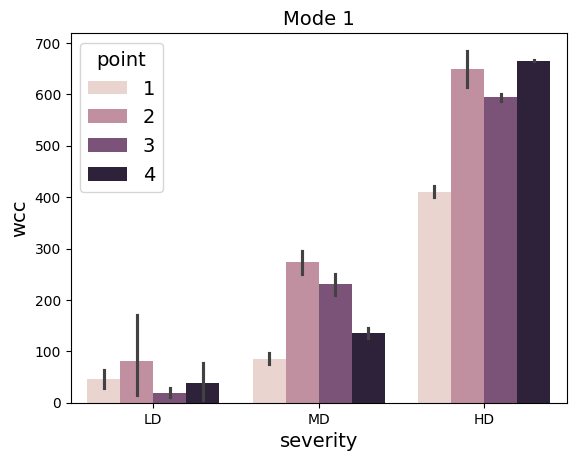

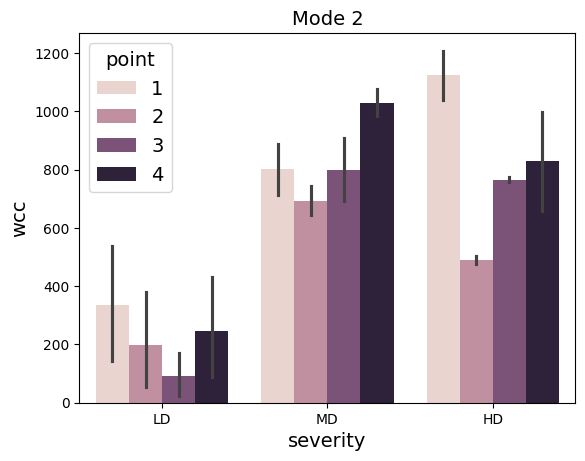

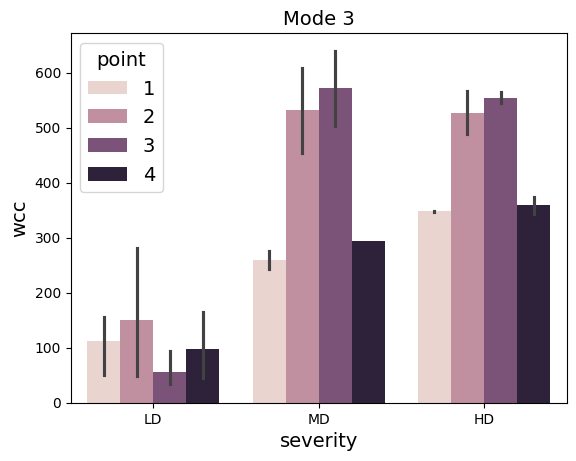

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
sns.barplot(x='severity', y='wcc', hue= 'point', data=df[df['mode_shape'] == 1], ax=ax1)
ax1.set_title('Mode 1')

fig2, ax2 = plt.subplots()
sns.barplot(x='severity', y='wcc', hue= 'point', data=df[df['mode_shape'] == 2], ax=ax2)
ax2.set_title('Mode 2')

fig3, ax3 = plt.subplots()
sns.barplot(x='severity', y='wcc', hue= 'point', data=df[df['mode_shape'] == 3], ax=ax3)
ax3.set_title('Mode 3')

- Only Mode shape 1 that will be used since it is more sensitive in classify damage severity and its location

In [105]:
df = pd.concat([wcc_ld, wcc_md, wcc_FEAhd[(wcc_FEAhd['mode_shape'] == 1)].iloc[4:]], axis=0)
df = df[(df['mode_shape'] == 1)]
df['severity_point'] = df['severity'].astype(str) + '_' + df['point'].astype(str)
# Create a dictionary that maps each unique value in 'severity_point' to a unique integer
labels = df['severity_point'].unique()
label_dict = {k: v for v, k in enumerate(labels)}
# Use the dictionary to replace the values in 'severity_point' with their corresponding labels
df['severity_point'] = df['severity_point'].map(label_dict)

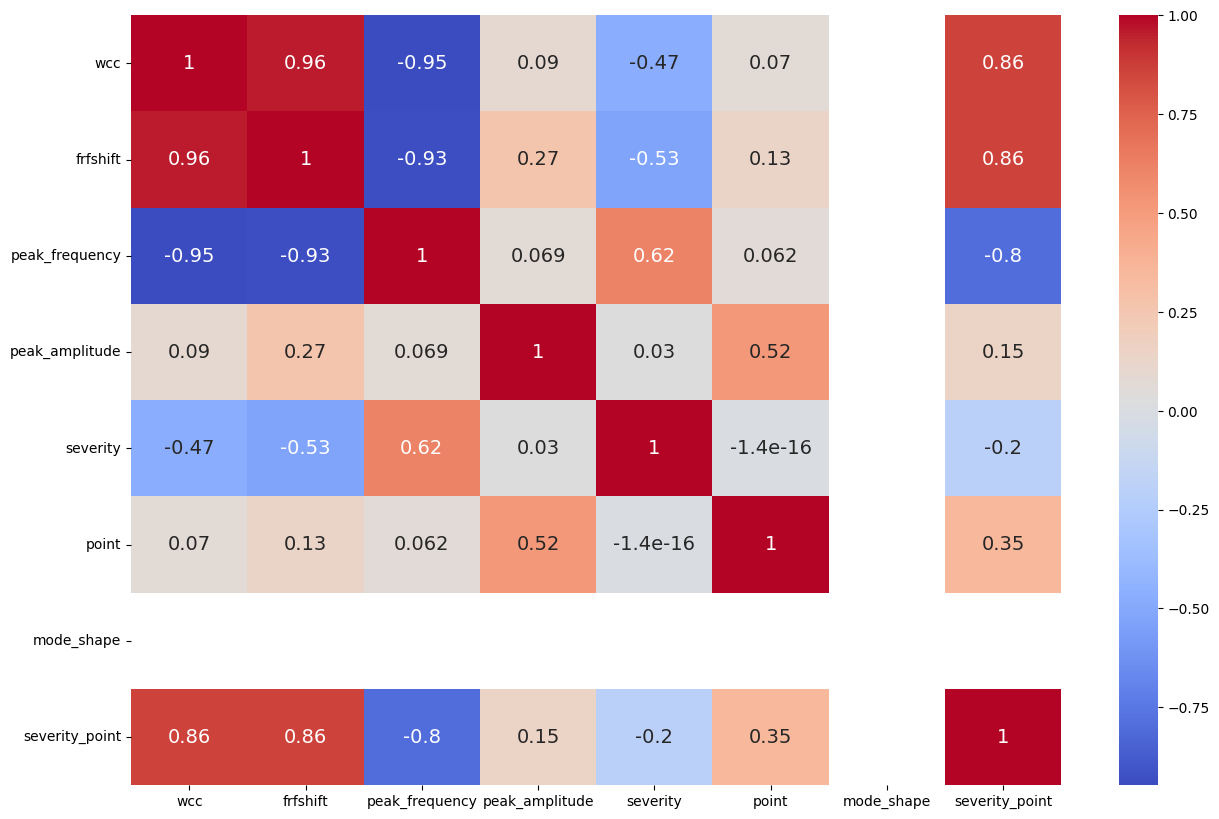

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['severity'] = le.fit_transform(df['severity'])
corr_matrix = df.corr(numeric_only=True)
corr_matrix["severity"].sort_values(ascending=False)

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

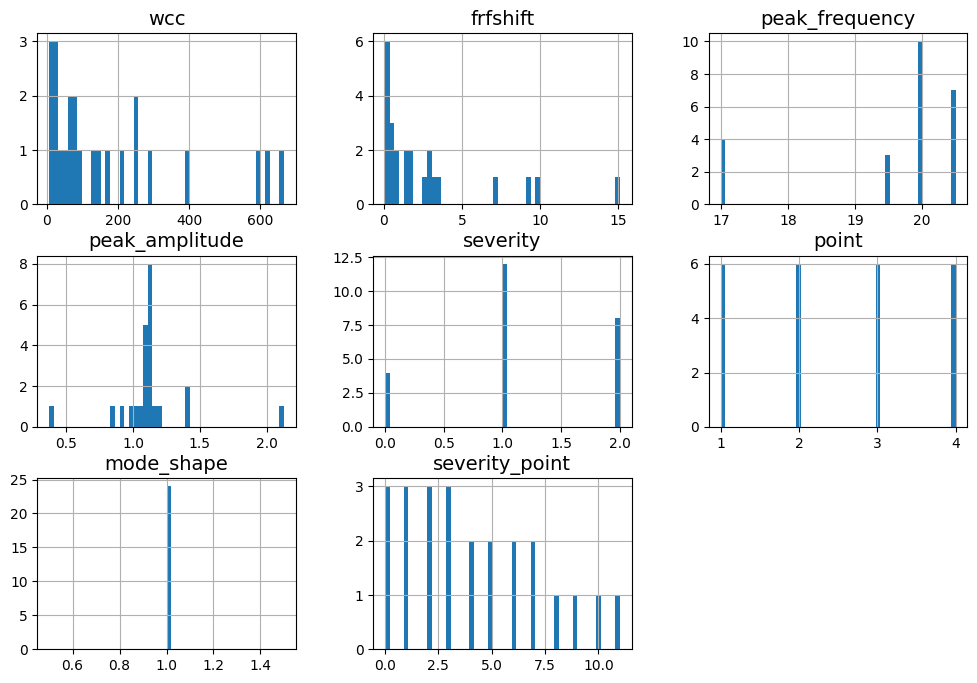

In [73]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8))
plt.show()

In [74]:
df.isnull().sum()

wcc               0
frfshift          0
peak_frequency    0
peak_amplitude    0
severity          0
point             0
mode_shape        0
severity_point    0
dtype: int64

# 3. Split Test Train Set and Data Augmentation

In [106]:
def bootstrap_sample_with_noise(data, exclude_cols=[], n_bootstrap_samples=15000, noise_scale=0.5):
    n_bootstrap_samples = 15000
    sample = data.sample(n=n_bootstrap_samples, replace=True).copy()  # Create a copy to avoid modifying original data
    
    # Identify numeric columns
    numeric_cols = sample.select_dtypes(include=[np.number]).columns
    
    # Exclude specified columns
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Add noise only to numeric columns
    noise = np.random.normal(0, noise_scale, size=(n_bootstrap_samples, len(numeric_cols)))
    sample[numeric_cols] += noise
    
    # Apply absolute value to ensure data is non-negative
    sample[numeric_cols] = sample[numeric_cols].abs()
    
    return sample

# Specify columns to exclude from noise addition
exclude_cols = ['point', 'mode_shape','peak_frequency', 'severity_point','peak_amplitude']
# Generate synthetic data with noise
wcc_noisy = bootstrap_sample_with_noise(df, exclude_cols=exclude_cols)

df = pd.concat([df, wcc_noisy], axis=0)
# Separate features and labels

X = df[['wcc', 'frfshift', 'peak_frequency', 'peak_amplitude']].values
y = df['severity_point'].values


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [107]:
from imblearn.over_sampling import SMOTE
from collections import Counter
#Define SMOTE
sm = SMOTE()

# Fit SMOTE on the training data
X_train, y_train = sm.fit_resample(X_train, y_train)

# Summarize the new class distribution
print("After oversampling: ", Counter(y_train))

After oversampling:  Counter({0: 1533, 11: 1533, 7: 1533, 9: 1533, 10: 1533, 3: 1533, 2: 1533, 6: 1533, 1: 1533, 5: 1533, 8: 1533, 4: 1533})


In [108]:
X_train = pd.DataFrame(X_train, columns=['wcc', 'frfshift', 'peak_frequency', 'peak_amplitude'])
X_train

,wcc,frfshift,peak_frequency,peak_amplitude
0,28.668929,1.382842,20.5,1.140537
1,63.771423,0.697078,20.0,1.112678
2,666.120178,14.617527,17.0,2.129556
3,664.954725,15.509253,17.0,2.129556
4,45.466539,0.416397,20.0,1.132941
...,...,...,...,...
18391,666.488696,15.535741,17.0,2.129556
18392,665.590113,14.566971,17.0,2.129556
18393,666.140940,15.096488,17.0,2.129556
18394,666.251148,15.974562,17.0,2.129556


In [109]:
y

array([0, 1, 2, ..., 3, 3, 5], dtype=int64)

In [110]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the targets
y_train = to_categorical(y_train, num_classes=12)
y_test = to_categorical(y_test, num_classes=12)  # Do the same for the test targets if you have them

# 4. Model Design and Training

In [111]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(12, activation='softmax')  # 12 classes for multiclass classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


c:\Users\dania\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4108 - loss: 3.7998 - val_accuracy: 0.4261 - val_loss: 4.2928
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6768 - loss: 0.9648 - val_accuracy: 0.4277 - val_loss: 2.1653
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7483 - loss: 0.7146 - val_accuracy: 0.7139 - val_loss: 2.9080
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7962 - loss: 0.5683 - val_accuracy: 0.4351 - val_loss: 2.9883
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8132 - loss: 0.4791 - val_accuracy: 0.7174 - val_loss: 0.4569
Epoch 6/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8458 - loss: 0.3430 - val_accuracy: 0.7174 - val_loss: 0.4841
Epoch 7/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8496 - loss: 0.3248 - val_accuracy: 0.7071 - val_loss: 0.7030
Epoch 8/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8513 - loss: 0.3162 - val_accuracy: 0.7174

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[359   0   7   0   0   0   0   0   0   0   0   0]
 [  0 401   0   0   0   0   0   0   0   0   0   0]
 [  3   0 349   0   0   0   0   0   0   0   0   0]
 [  0   0   0 360   1   0   0   0   0   0   0   0]
 [  0   0   0   0 254   0   0   0   0   0   0   0]
 [  0   0   0   0   0 241  39   0   0   0   0   0]
 [  0   0   0   0   0  62 174   0   0   0   0   0]
 [  0   0   0   0   0   0   0 271   0   0   0   0]
 [  0   0   0   0   0   0   0   0 115   0   0   0]
 [  0   0   0   0   0   0   0   0   0 123   6   0]
 [  0   0   0   0   0   0   0   0   0   0 119   0]
 [  0   0   0   0   0   0   0   0   0   0   0 121]]


<Figure size 1000x1000 with 0 Axes>

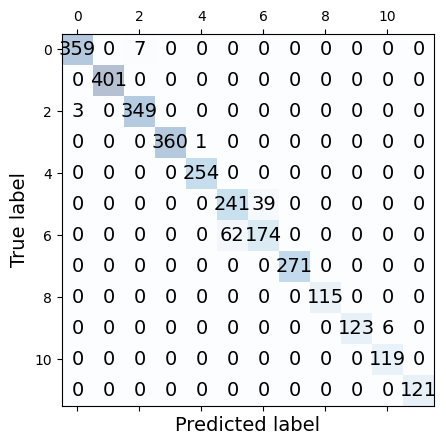

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       366
           1       1.00      1.00      1.00       401
           2       0.98      0.99      0.99       352
           3       1.00      1.00      1.00       361
           4       1.00      1.00      1.00       254
           5       0.80      0.86      0.83       280
           6       0.82      0.74      0.78       236
           7       1.00      1.00      1.00       271
           8       1.00      1.00      1.00       115
           9       1.00      0.95      0.98       129
          10       0.95      1.00      0.98       119
          11       1.00      1.00      1.00       121

    accuracy                           0.96      3005
   macro avg       0.96      0.96      0.96      3005
weighted avg       0.96      0.96      0.96      3005



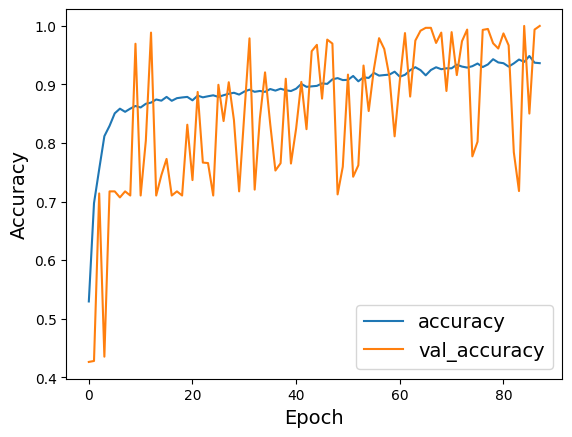

In [112]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Convert predicted probabilities to class labels
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Now y_pred contains class labels, which can be used with classification_report and confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), y_pred)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

print(classification_report(np.argmax(y_test, axis=-1), y_pred))

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 5. Save the entire model to a HDF5 file
model.save('my_model.h5')

In [139]:
# Save the entire model to a HDF5 file
model.save('my_model.keras')


In [37]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('my_model.keras')

c:\Users\dania\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# 6. Test with Experimental Modal Analysis Dataset of High Damage Severity

In [136]:
wcc_hd = pd.read_excel('./test/wcc_HD.xlsx')
wcc_hd = wcc_hd[(wcc_hd['mode_shape'] == 1)]
wcc_hd['severity_point'] = wcc_hd['severity'].astype(str) + '_' + wcc_hd['point'].astype(str)
wcc_hd = wcc_hd.drop(["severity","mode_shape","point",], axis=1)
wcc_hd
wcc_hd['severity_point'] = wcc_hd['severity_point'].map(label_dict)
wcc_hd.head()

,wcc,frfshift,peak_frequency,peak_amplitude,severity_point
0,308.712078,7.680376,16.5,0.441857,8
3,512.404811,10.349958,15.5,0.885045,9
6,481.689882,9.828734,16.0,0.764737,10
9,532.226787,14.963518,16.5,2.162405,11
12,310.973295,7.727579,16.5,0.444164,8


In [ ]:
wcc_FEAhd[(wcc_FEAhd['mode_shape'] == 1)].iloc[4:]

,wcc,frfshift,peak_frequency,peak_amplitude,severity,point,mode_shape
12,400.277900,7.071750,17.0,0.369735,HD,1,1
15,614.496863,9.896280,17.0,1.015607,HD,2,1
18,587.279162,9.207289,17.0,0.861799,HD,3,1
21,666.004619,15.089849,17.0,2.129556,HD,4,1


In [137]:
x_wcc_hd = wcc_hd[['wcc', 'frfshift', 'peak_frequency', 'peak_amplitude']].values
y_wcc_hd = wcc_hd['severity_point'].values
y_wcc_hd = to_categorical(y_wcc_hd, num_classes=12)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]


<Figure size 1000x1000 with 0 Axes>

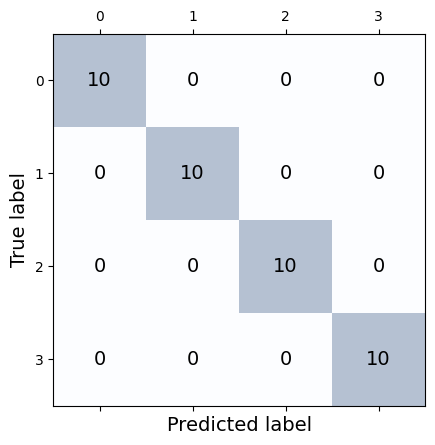

              precision    recall  f1-score   support

        HD_1       1.00      1.00      1.00        10
        HD_2       1.00      1.00      1.00        10
        HD_3       1.00      1.00      1.00        10
        HD_4       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [138]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Define the mapping from class indices to labels
class_labels = {8: 'HD_1', 9: 'HD_2', 10: 'HD_3', 11: 'HD_4'}

# Convert predicted probabilities to class labels
y_pred_wcc_hd = np.argmax(model.predict(x_wcc_hd), axis=-1)
y_pred_wcc_hd_labels = [class_labels[i] for i in y_pred_wcc_hd]

# Convert one-hot encoded true labels to their original form
y_true_wcc_hd = np.argmax(y_wcc_hd, axis=-1)
y_true_wcc_hd_labels = [class_labels[i] for i in y_true_wcc_hd]

# Now y_pred and y_true contain class labels, which can be used with classification_report and confusion_matrix
cm = confusion_matrix(y_true_wcc_hd_labels, y_pred_wcc_hd_labels)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

print(classification_report(y_true_wcc_hd_labels, y_pred_wcc_hd_labels))

In [100]:
wcc_FEAhd[(wcc_FEAhd['mode_shape'] == 1)].iloc[4:]

,wcc,frfshift,peak_frequency,peak_amplitude,severity,point,mode_shape
12,400.277900,7.071750,17.0,0.369735,HD,1,1
15,614.496863,9.896280,17.0,1.015607,HD,2,1
18,587.279162,9.207289,17.0,0.861799,HD,3,1
21,666.004619,15.089849,17.0,2.129556,HD,4,1
